# Add extra column with linear parameters to Planck chains

This notebook shows how to read Planck chain, and compute linear power parameters for each point in the chain.

Actually, the code is fairly slow, so it only does this for a handful of points in the chain. Heavier work is done with a python script in cup1d/scripts/add_linP_chains.py

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import os
from getdist import plots
from cup1d.planck import planck_chains
from cup1d.planck import add_linP_params
# because of black magic, getdist needs this strange order of imports
%matplotlib inline

### Read Planck 2018 chain

In [2]:
# this should be the original Planck chain, but instead I'm using a lighter version stored in cup1d
cmb=planck_chains.get_planck_2018(model='base_mnu')

((0.2803125188751192, 0.4003302811248808),
 (0.947552819828408, 0.981410780171592))

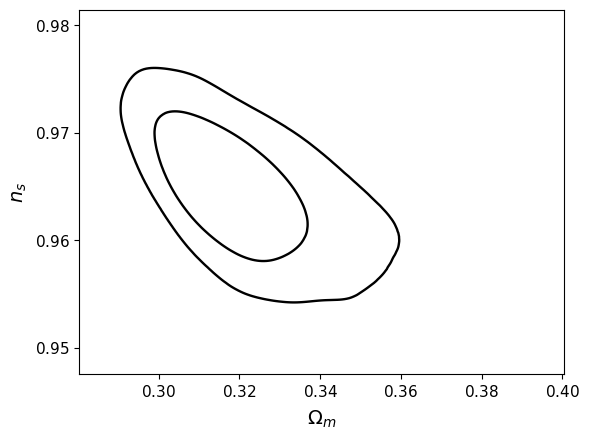

In [3]:
g = plots.getSinglePlotter()
g.plot_2d(cmb['samples'], ['omegam', 'ns'])

In [4]:
# dramatically reduce sice of chain, for testing
samples=cmb['samples'].copy()
thinning=200
samples.thin(thinning)
Nsamp,Npar=samples.samples.shape
print('Thinned chains have {} samples and {} parameters'.format(Nsamp,Npar))

Thinned chains have 32 samples and 99 parameters


### For each element in the chain, compute and store linear power parameters

In [5]:
# specify linear power parameters that we want to add
linP_params_names=['Delta2_star','n_star','f_star','g_star','alpha_star']
# this will collect a dictionary for each sample in the chain
linP_params_entries=[]
for i in range(Nsamp):
    verbose=(i%10==0)
    if verbose: print('sample point',i)
    # get point from original chain
    params=samples.getParamSampleDict(i)
    # compute linear power parameters (n_star, f_star, etc.)
    linP_params=add_linP_params.get_linP_params(params,verbose=verbose)
    # add only the relevant ones
    linP_params_entries.append({k: linP_params[k] for k in linP_params_names})
    if verbose: print('linP params',linP_params_entries[-1])

sample point 0
H0 = 6.5313E+01, Omega_b h^2 = 2.2154E-02, Omega_c h^2 = 1.2151E-01, Omega_k = 0.0000E+00, Omega_nu h^2 = 2.0472E-03, A_s = 2.1033E-09, n_s = 9.5908E-01, alpha_s = 0.0000E+00
linP params {'Delta2_star': 0.3407831616461373, 'n_star': -2.3052885326505175, 'f_star': 0.9880154829305521, 'g_star': 0.9711115471075301, 'alpha_star': -0.2163314615567835}
sample point 10
H0 = 6.7431E+01, Omega_b h^2 = 2.2314E-02, Omega_c h^2 = 1.2073E-01, Omega_k = 0.0000E+00, Omega_nu h^2 = 3.0487E-04, A_s = 2.0916E-09, n_s = 9.6960E-01, alpha_s = 0.0000E+00
linP params {'Delta2_star': 0.3633193556445136, 'n_star': -2.294728970340068, 'f_star': 0.9821900316586837, 'g_star': 0.9675398226768048, 'alpha_star': -0.21644867317524338}
sample point 20
H0 = 6.6097E+01, Omega_b h^2 = 2.2284E-02, Omega_c h^2 = 1.2077E-01, Omega_k = 0.0000E+00, Omega_nu h^2 = 1.6717E-03, A_s = 2.1196E-09, n_s = 9.5799E-01, alpha_s = 0.0000E+00
linP params {'Delta2_star': 0.34223360563294475, 'n_star': -2.307127679717943, '

In [6]:
# setup numpy arrays with linP parameters
linP_DL2_star=np.array([linP_params_entries[i]['Delta2_star'] for i in range(Nsamp)])
linP_n_star=np.array([linP_params_entries[i]['n_star'] for i in range(Nsamp)])

In [7]:
# add new derived linP parameters 
samples.addDerived(linP_DL2_star,'test_linP_DL2_star',label='Ly\\alpha \\, \\Delta_\\ast')
samples.addDerived(linP_n_star,'test_linP_n_star',label='Ly\\alpha \\, n_\\ast')

In [8]:
# get basic statistics for the new parameters
param_means=np.mean(samples.samples,axis=0)
param_vars=np.var(samples.samples,axis=0)
print('DL2_star mean = {} +/- {}'.format(param_means[Npar],np.sqrt(param_vars[Npar])))
print('n_star mean = {} +/- {}'.format(param_means[Npar+1],np.sqrt(param_vars[Npar+1])))

DL2_star mean = 0.3533516023091078 +/- 0.010537766081768799
n_star mean = -2.3006265363402676 +/- 0.0037448247826760046


### Write extended chains to file

In [9]:
new_root='./test_linP'
if (thinning > 1.0):
    new_root+='_'+str(thinning)
print('new root',new_root)
samples.saveAsText(root=new_root,make_dirs=True)

new root ./test_linP_200


In [10]:
# Try reading the new file
from getdist import loadMCSamples
new_samples = loadMCSamples(new_root)
# get basic statistics for the new parameters
new_param_means=np.mean(new_samples.samples,axis=0)
new_param_vars=np.var(new_samples.samples,axis=0)
print('old DL2_star mean = {} +/- {}'.format(param_means[Npar],np.sqrt(param_vars[Npar])))
print('new DL2_star mean = {} +/- {}'.format(new_param_means[Npar],np.sqrt(new_param_vars[Npar])))

./test_linP_200.txt
Removed no burn in
old DL2_star mean = 0.3533516023091078 +/- 0.010537766081768799
new DL2_star mean = 0.353351602375 +/- 0.010537766101187727
